# Excercise no. 4
Max Kahl, Marvin Kinz, Konstantin Neureither


### Requirements and Google Colab setup
The requirements that you will need for this assigment are:

- If you work on Google Colab:
    - tensorboardX
    - a small utility called `ngrok` that let you see the Tensorboard panel in a separate webpage
- If you use your local GPU with your local environment:
    - (PyTorch)
    - tensorboardX
    - tensorboard (included if you already have tensorflow)

In [4]:
#### RUN THIS CODE IF YOU USE GOOGLE COLAB ####

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the material for this assignment,
# e.g. 'cvf20/assignments/assignment3/'
FOLDERNAME = 'STUDIUM/HEIDELBERG/CVF/EX04/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Make sure that the python modules in the assignment folder are found by the notebook:
import sys
import os
path_drive = os.path.join("/content/drive/My Drive", FOLDERNAME)
sys.path.append(path_drive)

# Copy the yeast-cells data in the content folder of the notebook:
dataset_path = os.path.join(path_drive, "yeast_cells_dataset") 
dataset_path = dataset_path.replace(" ", "\ ")
!cp -r $dataset_path ./

path_images = os.path.join("drive/My Drive", FOLDERNAME)
path_images = os.path.join(path_images, "img")

# Move to the main content folder:
%cd /content

# Install tensorboardX:
!pip install tensorboardX

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content
     |████████████████████████████████| 204kB 2.8MB/s 


In [5]:
#### RUN THIS CODE IF YOU USE GOOGLE COLAB OR IF YOU WANT TO USE THE NGROK UTILITY ####

! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2020-06-02 08:39:50--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.214.66.67, 54.159.115.94, 35.175.20.97, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.214.66.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  6.04MB/s    in 2.2s    

2020-06-02 08:39:53 (6.04 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


# 1. Train a CNN for Semantic Segmentation (Part 2)

In [6]:
# The usual imports:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import imageio
import scipy.ndimage
plt.rcParams['figure.figsize'] = [15, 15]

import torch
from torch import nn
import h5py
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### a) Loss functions for semantic segmentation
In the code block below, implement the Dice loss defined in the description of the assignment. We will implement it as a subclass of `torch.nn.Module`, which is the base PyTorch class for all neural network modules. The method `forward()` is the one that performs the forward step, i.e. computes the output of the layer from the given inputs. 

We don't need to implement Binary Cross Entropy, since it is already implemented in PyTorch.

In [0]:
class SorensenDiceLoss(nn.Module):
    """
    Computes a loss scalar, which when minimized maximizes the Sorensen-Dice similarity
    between the input and the target.
    """
    def __init__(self, eps=1e-6):
        super(SorensenDiceLoss, self).__init__()
        self.eps = eps

    def forward(self, input, target):
        """
        input:      torch.FloatTensor with float values between 0 and 1
        target:     torch.FloatTensor with binary values 0 and 1

        Shape of the inputs: (batch_size, 1, x_size_image, y_size_image)
        
        When you divide by the denominator in the Dice loss formula, you can use the `eps` parameter and the
        `clamp` method to avoid a division by zero:
        
         loss = 1 - 2 * (numerator / denominator.clamp(min=self.eps))
        
        """
        assert input.shape == target.shape
        loss = None
        

        ### Your code starts here:
        partialloss =  0.0
        batch_size, one, x_size_image, y_size_image = input.shape

        for n in range(batch_size):
          numerator = torch.sum(input[n][0] * target[n][0])
          denominator = torch.sum(input[n][0] * input[n][0]) + torch.sum(target[n][0] * target[n][0])
          partialloss = partialloss + 1 - 2 * (numerator / denominator.clamp(min=self.eps))

        loss = partialloss * 1/batch_size
        
        ### Your code ends here
        return loss


In [8]:
# Test your implementation:
test_pred, test_gt = torch.zeros((1,1,5,5)), torch.zeros((1,1,5,5))
test_pred[0,0,0,:3] = 0.8
test_gt[0,0,0,2:] = 1

loss_function = SorensenDiceLoss()
loss = loss_function(test_pred, test_gt)
if loss is not None:
    if np.allclose(loss.item(), 0.67479676):
        print("Your implementation is correct!")
    else:
        print("There is some problem in your implementation")

Your implementation is correct!


### b) Training a UNet model
Some information about the code that is provided:

- In `cvf20/transforms.py` and `cvf20/metrics.py` you can find the data augmentation functions and the metrics that you implemented in the last assignment.
- In `cvf20/utils.py` you can find a function to normalize the data. We will use the first 14 images for training and the last 4 for validation.
- The implementation of the `UNet` model is in `cvf20/models/UNet.py`. In the code block below you find an example of basic UNet model with depth 5 and the correct number of input/output channels needed for our foreground/background task.

##### Task 1.) Creating the data loaders
First, let's create the data loaders as we did in the last assignment

In [0]:
from cvf20.utils import normalize_dataset
from cvf20.datasets import YeastCellDataset
import cvf20.transforms as T
from torch.utils.data.dataloader import DataLoader

# Compose and normalize the data in a .hdf5 file:
normalize_dataset()

# Add the transformations we used last time:
all_transforms = T.Compose(
    T.RandomFlip(),
    T.RandomRotation(),
    T.ToTorchTensor()
)

# For training, we choose a stride = (64,64). In this way during an epoch the same portion of an image are
# seen multiple times, but we make sure that some parts are not always feeded at the border of the 
# training (512,512) window. 
# In your experiments you can tweak this parameter (smaller value equal to more iterations in one epoch):
train_dataset = YeastCellDataset('./yeast_cells_dataset/dataset.hdf5',
                          (512,512),
                          (64,64),
                          mode="train",
                          transforms=all_transforms
                        )

# For validation, we make sure to visit the data only once (so we set stride=(512,512)):
val_dataset = YeastCellDataset('./yeast_cells_dataset/dataset.hdf5',
                          (512,512),
                          (512,512), 
                          mode="val",
                          transforms=all_transforms
                        )

# Create the data loaders:
train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        drop_last=True,
        num_workers=2
)
val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=True,
        drop_last=True,
        num_workers=2
)


##### Task 2.) Using a GPU
Then, let's check if CUDA is available, i.e. if we can train on a GPU:

In [10]:
# We will be using float throughout this tutorial
dtype = torch.float32 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("Warning, GPU not available! Please make sure to use one otherwise the training will be VERY slow")

print('Using device:', device)

Using device: cuda


##### Task 3.) The Trainer Class
In the next code block you will find the `Trainer` class that you will use to train your model. It includes code to perform the training iterations, compute the loss, update the parameters in the neural network, evaluate the metrics and log data during training.

Considering the goal of this exercise, it is not strictly needed to understand every line of code in it. But if you are eager to learn more, the code below will give you a good idea of how the PyTorch mechanics work.

In [0]:
from cvf20.metrics import compute_accuracy, compute_IoU
from tensorboardX import SummaryWriter

class Trainer(object):
    def __init__(self, experiment_name, model,
                 optimizer, loss_function,
                 loader_train, loader_val,
                 dtype, device,
                 print_every=200, validate_every=100):
        """
        :param experiment_name: Name of the experiment. A folder with the name 'experiments/experiment_name` will be
                created with all the data associated to this run.

        :param model: PyTorch model of the neural network

        :param optimizer: PyTorch optimizer

        :param print_every: How often should we print the loss during training (and send some training plots to
                tensorboard)

        :param validate_every: How often (after how many training iterations) should we evaluate the results on the
                validation set (and send some validation plots to tensorboard)
        """
        # Create attributes:
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.loader_train = loader_train
        self.loader_val = loader_val
        self.validate_every = validate_every
        self.print_every = print_every
        self.device = device
        self.dtype = dtype

        # Create experiment directory:
        exp_path = os.path.join('experiments', experiment_name)
        os.makedirs(exp_path, exist_ok=True)

        # Create Tensorboard logger:
        self.writer = SummaryWriter(exp_path)

    def train_model(self, epochs=1):
        """
        - epochs: (Optional) An integer giving the number of epochs to train for
        """
        model = self.model.to(device=self.device)  # move the model parameters to CPU/GPU
        nb_iter_per_epoch = 0
        for e in range(epochs):
            for t, (input, target) in enumerate(self.loader_train):
                model.train()  # put model to training mode
                input = input.to(device=self.device, dtype=self.dtype)  # move to device, e.g. GPU
                target = target.to(device=self.device, dtype=self.dtype)

                prediction = model(input)
                loss = self.loss_function(prediction, target)

                # Zero out all of the gradients for the variables which the optimizer
                # will update.
                self.optimizer.zero_grad()

                # This is the backwards pass: compute the gradient of the loss with
                # respect to each  parameter of the model.
                loss.backward()

                # Actually update the parameters of the model using the gradients
                # computed by the backwards pass.
                self.optimizer.step()

                # Make sure that we apply a final activation if it was not done already:
                if self.model.final_activation is None:
                    prediction = torch.sigmoid(prediction)

                # Compute metrics:
                accuracy = compute_accuracy(prediction, target)
                IoU = compute_IoU(prediction, target)

                # Log some data to tensorboard:
                self.writer.add_scalar('loss_train', loss.item(), t + e * nb_iter_per_epoch)
                self.writer.add_scalar('IoU_train', IoU.item(), t + e * nb_iter_per_epoch)
                self.writer.add_scalar('accuracy_train', accuracy.item(), t + e * nb_iter_per_epoch)

                if t % self.print_every == 0:
                    self.make_plots(input, prediction, target, t + e * nb_iter_per_epoch, "predictions_train")
                    string1 = f'Epoch {e + 1}, iter {t}'
                    string2 = f'Loss: {loss.item()}'
                    print('{:<25s} ---> \t{:<30s}'.format(string1, string2))

                if t % self.validate_every == 0:
                    self.evaluate_metrics_on_val_set(t + e * nb_iter_per_epoch)

                # Increase counter:
                if e == 0:
                    nb_iter_per_epoch += 1

    def evaluate_metrics_on_val_set(self, global_step=None):
        # Set model to evaluation mode:
        # this is very important because some types of layers (for example BatchNorm) behave differently
        # during training and during evaluation.
        self.model.eval()

        # From now on, we make sure that torch does store data for computing gradients, since we won't
        # update the parameters of the model during validation. This makes the computations faster and
        # uses much less GPU memory.
        with torch.no_grad():
            # During validation, we accumulate these values across the whole dataset and then average at the end:
            accuracy, IoU, loss = 0., 0., 0.
            nb_iter = 0
            for input, target in self.loader_val:
                input = input.to(device=self.device, dtype=self.dtype)  # move to device, e.g. GPU
                target = target.to(device=self.device, dtype=self.dtype)
                prediction = self.model(input)
                loss = loss + self.loss_function(prediction, target)

                # Make sure that we apply a final activation if it was not done already:
                if self.model.final_activation is None:
                    prediction = torch.sigmoid(prediction)

                accuracy = accuracy + compute_accuracy(prediction, target)
                IoU = IoU + compute_IoU(prediction, target)
                if nb_iter == 0:
                    self.make_plots(input, prediction, target, global_step, name_figure="predictions_val")
                nb_iter += 1
            
            loss = loss / nb_iter
            IoU = IoU / nb_iter
            accuracy = accuracy / nb_iter
            if global_step is not None:
                # Log scores averaged over all the valid set (send them to tensorboard):
                self.writer.add_scalar('loss_validation', loss.item(), global_step)
                self.writer.add_scalar('IoU_validation', IoU.item(), global_step)
                self.writer.add_scalar('accuracy_validation', accuracy.item(), global_step)
            else:
                # Print the results and return them:
                print("Validation loss function: ", loss.item())
                print("Validation IoU: ", IoU.item())
                print("Validation accuracy: ", accuracy.item())
                return loss.item(), IoU.item(), accuracy.item() 

    def make_plots(self, input, predictions, targets,
                   step, name_figure="image_log"):
        # First, we need to move the data back to CPU:
        input = input.cpu().detach().numpy()
        predictions = predictions.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()

        # Then we create some plots
        f, axes = plt.subplots(ncols=4, nrows=predictions.shape[0], figsize=(8, 8))
        for ax in axes.flatten():
            ax.axis('off')  # Delete axes
        axes[0, 0].set_title("Input image")
        axes[0, 1].set_title("Yeast-cell\nprediction")
        axes[0, 2].set_title("Ground truth")
        axes[0, 3].set_title("Pixels not\ncorrectly classified")
        for btc in range(predictions.shape[0]):
            axes[btc, 0].imshow(input[btc, 0], cmap='gray')
            axes[btc, 1].imshow(predictions[btc, 0], cmap='gray', vmin=0, vmax=1)
            axes[btc, 2].imshow(targets[btc, 0], cmap='gray', vmin=0, vmax=1)
            axes[btc, 3].imshow((predictions[btc, 0] > 0.5) == targets[btc, 0], cmap='seismic_r')
        plt.tight_layout()  # Reduce padding between subplots

        self.writer.add_figure(name_figure, f, step)  # Send the plot to tensorboard



##### Task 4.) Your first experiment!
In the next block we create a UNet model, build the Adam optimizer that will take care of updating the parameters and then start the training. You can choose an `experiment_name` to be passed to the `Trainer` class, so that you will find all the data related to it in the folder `experiments/experiment_name`. 

**Remark about the number of epochs:** Observing the loss plots during the first epoch is already enough to see if there are some bugs in your implementation. Running scripts on Google Colab seems to take longer than on a local GPU, but after few epochs (max 5) you should already be able to draw your conclusions. On a local GPU, 10 epochs will take approximately one hour. In the bonus exercise, you can decide to let your best model train longer to see how good it can get.

In [63]:
### NAME EXPERIMENT: first experiment with Soresen-Dice Loss ###

from cvf20.models.unet import UNet

# Build a basic UNet model:
starting_model = UNet(
     depth=5,
     in_channels=1,
     out_channels=1,
     fmaps=(16, 32, 64, 128, 512, 1024),
     dim=2,
     scale_factor=2,
     activation=nn.ReLU,
     final_activation=nn.Sigmoid
)

# Build the optimizer:
params = starting_model.parameters()
learning_rate = 1e-4
optimizer = torch.optim.AdamW(params, lr=learning_rate)

# Build the trainer with the Soresen-Dice loss you implemented:
trainer = Trainer('first_exp_diceLoss', starting_model, optimizer, SorensenDiceLoss(),
        train_loader, val_loader, dtype, device)

# Start training:
trainer.train_model(epochs=10)
final_scores = trainer.evaluate_metrics_on_val_set()

Epoch 1, iter 0           ---> 	Loss: 0.4465007185935974      
Epoch 1, iter 200         ---> 	Loss: 0.10714446008205414     
Epoch 1, iter 400         ---> 	Loss: 0.05430901050567627     
Epoch 2, iter 0           ---> 	Loss: 0.08640061318874359     
Epoch 2, iter 200         ---> 	Loss: 0.06229017674922943     
Epoch 2, iter 400         ---> 	Loss: 0.038296177983284       
Epoch 3, iter 0           ---> 	Loss: 0.04383915662765503     
Epoch 3, iter 200         ---> 	Loss: 0.04194381833076477     
Epoch 3, iter 400         ---> 	Loss: 0.03726638853549957     
Epoch 4, iter 0           ---> 	Loss: 0.03842915594577789     
Epoch 4, iter 200         ---> 	Loss: 0.03340531885623932     
Epoch 4, iter 400         ---> 	Loss: 0.02881734073162079     
Epoch 5, iter 0           ---> 	Loss: 0.026784196496009827    
Epoch 5, iter 200         ---> 	Loss: 0.043085917830467224    
Epoch 5, iter 400         ---> 	Loss: 0.04487520456314087     
Epoch 6, iter 0           ---> 	Loss: 0.027950137853622

##### Task 5.) Have a look at what it was logged in Tensorboard!
By running the following code block, as an output you will get a link that you can use to see tensorboard in a separate webpage (if you are using Google Colab). If instead you are using your local conda environment, then you can find tensorboard at [http://localhost:6006](http://localhost:6006).

In Tensorboard, you will see two icons in the upper orange bar: `Scalars` (showing scores and value of the loss) and `Images`.

If you are not happy with one experiment and you want to delete the data from Tensorboard, just delete the folder `experiments/experiment_name` containing its data (for example by running `!rm -r ./experiments/experiment_name`)


In [0]:
### RUN THIS CODE TO START TENSORBOARD ###
LOG_DIR = './experiments'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [33]:
### RUN THIS CODE IF YOU USE GOOGLE COLAB AND YOU WANT TO SEE TENSORBOARD IN ANOTHER WEBPAGE (output link) ###
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://3360a8f286d3.ngrok.io


In [0]:
### RUN THIS CODE IF YOU USE GOOGLE COLAB AND YOU WANT TO SEE TENSORBOARD HERE IN THE NOTEBOOK ###
# Remark: This method is less preferred because this embedded interface seems to be less responsive 
# and it does not allow to download images of the plots
%load_ext tensorboard
%tensorboard --logdir experiments

##### Task 6.) Binary Cross Entropy Loss
Now run another experiment using this different type of loss. With this loss function, sometimes the training works  better if you remove the final `Sigmoid` activation from the model and use the loss `torch.nn.BCEWithLogitsLoss`, which combines a Sigmoid layer and the `torch.nn.BCELoss` in one single class to avoid outputs with infinite values.


In [0]:
### NAME EXPERIMENT: second experiment with BCE Loss ###

from cvf20.models.unet import UNet

### Your code starts here (see first experiments above) ###
# Build a basic UNet model:
starting_model = UNet(
     depth=5,
     in_channels=1,
     out_channels=1,
     fmaps=(16, 32, 64, 128, 512, 1024),
     dim=2,
     scale_factor=2,
     activation=nn.ReLU,
     final_activation=nn.Sigmoid
)

# Build the optimizer:
params = starting_model.parameters()
learning_rate = 1e-4
optimizer = torch.optim.AdamW(params, lr=learning_rate)

# Build the trainer with the BCE Loss:
trainer = Trainer('first_exp_BCELoss', starting_model, optimizer, torch.nn.BCEWithLogitsLoss(),
        train_loader, val_loader, dtype, device)

# Start training:
trainer.train_model(epochs=2)
final_scores = trainer.evaluate_metrics_on_val_set()
### Your code ends here ###

### First epoch
For a first run with one epoch, the results of the Soresen-Dice Loss already look promising with and accuracy of 0.917 and a IoU of 0.846. When observing the plots, one can already see, that the model improves over the first epoch quite dramatically, after encountering a big fall back after the first 100 iterations or so. The BCE implementation does only show little to none development in the first epoch. The results are also pretty bad with and accuracy of 0.532 and an IoU of only 0.266.

### Multiple epochs
Secondly we ran five epochs to train the model. For the test with Soresen-Dice Loss this actually does not show a huge improvement over the first epoch. The model continously evolves, but in very small steps, as it had reached a pretty good level from start. Also it can be observed, that there is no "jumps" in the accuracy graphs. This means, that the model decided very early to which minimum of the loss it should aim to. If this minimum was a local one however, this could become a problem. The results after five epochs were accuracy=0.951 and IoU=0.905. \\
The BCE model shows strange behavior. The loss converges at about 0.693 after the first 200 iterations. This means the whole model must have gotten stuck in a local minimum of the loss function with accuracy=0.532 and IoU=0.266. Both of which are quite bad values compared to the Soresen-Dice Loss.

The graphs show the training accuracy and the training loss for the first five epochs (orange=Soresen-Dice, blue=BCE)

Letting the model with Sorensen-Dice Loss train for 10 epochs leads to a IoU of 0.911, which passes our requirements. 


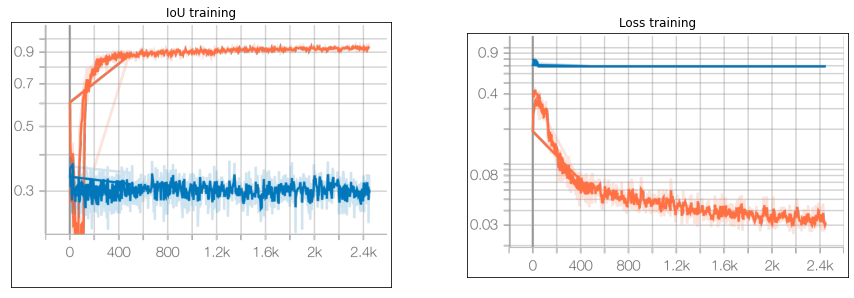

In [36]:
img = imageio.imread(os.path.join(path_images, 'IoU_train_ep5.png'))
ax = plt.subplot(1,2,1)
ax.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.imshow(img)
plt.title("IoU training")

img = imageio.imread(os.path.join(path_images, 'loss_train_ep5.png'))
ax = plt.subplot(1,2,2)
ax.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.imshow(img)
plt.title("Loss training")

plt.show()

##### Task 7.) Add normalization layers
Repeat the previous two experiments by adding normalization layers to the UNet model.

## nn.torch norm types
Some norms from the documentation.
```
torch.nn.BatchNorm1d
torch.nn.BatchNorm2d
torch.nn.BatchNorm3d
torch.nn.GroupNorm
torch.nn.SyncBatchNorm
torch.nn.LayerNorm
```

In [19]:
### NAME EXPERIMENT: third experiment with Soresen-Dice Loss and normalization layer ###

from cvf20.models.unet import UNet

### Your code starts here (see first experiments above) ###
# Build a basic UNet model:
starting_model = UNet(
     depth=5,
     in_channels=1,
     out_channels=1,
     fmaps=(16, 32, 64, 128, 512, 1024),
     dim=2,
     scale_factor=2,
     norm_type=torch.nn.BatchNorm2d,
     activation=nn.ReLU,
     final_activation=nn.Sigmoid
)

# Build the optimizer:
params = starting_model.parameters()
learning_rate = 1e-4
optimizer = torch.optim.AdamW(params, lr=learning_rate)

# Build the trainer with the Soresen-Dice loss you implemented:
trainer = Trainer('third_exp_diceLoss', starting_model, optimizer, SorensenDiceLoss(),
        train_loader, val_loader, dtype, device)

# Start training:
trainer.train_model(epochs=5)
final_scores = trainer.evaluate_metrics_on_val_set()
### Your code ends here ###

Epoch 1, iter 0           ---> 	Loss: 0.4549406170845032      
Epoch 1, iter 200         ---> 	Loss: 0.15660719573497772     
Epoch 1, iter 400         ---> 	Loss: 0.14506810903549194     
Epoch 2, iter 0           ---> 	Loss: 0.11267462372779846     
Epoch 2, iter 200         ---> 	Loss: 0.1161193698644638      
Epoch 2, iter 400         ---> 	Loss: 0.0764569491147995      
Epoch 3, iter 0           ---> 	Loss: 0.07410931587219238     
Epoch 3, iter 200         ---> 	Loss: 0.06543689966201782     
Epoch 3, iter 400         ---> 	Loss: 0.05177886784076691     
Epoch 4, iter 0           ---> 	Loss: 0.05366431176662445     
Epoch 4, iter 200         ---> 	Loss: 0.04895755648612976     
Epoch 4, iter 400         ---> 	Loss: 0.03805533051490784     
Epoch 5, iter 0           ---> 	Loss: 0.03668792545795441     
Epoch 5, iter 200         ---> 	Loss: 0.04228396713733673     
Epoch 5, iter 400         ---> 	Loss: 0.03329063951969147     
Validation loss function:  0.04549160599708557
Validati

In [29]:
### NAME EXPERIMENT: fourth experiment with BCE Loss and normalization layer ###

from cvf20.models.unet import UNet

### Your code starts here (see first experiments above) ###
# Build a basic UNet model:
starting_model = UNet(
     depth=5,
     in_channels=1,
     out_channels=1,
     fmaps=(16, 32, 64, 128, 512, 1024),
     dim=2,
     scale_factor=2,
     norm_type=torch.nn.BatchNorm2d,
     activation=nn.ReLU,
     final_activation=nn.Sigmoid
)

# Build the optimizer:
params = starting_model.parameters()
learning_rate = 1e-5
optimizer = torch.optim.AdamW(params, lr=learning_rate)

# Build the trainer with the BCE loss:
trainer = Trainer('fourth_exp_BCELoss', starting_model, optimizer, torch.nn.BCEWithLogitsLoss(),
        train_loader, val_loader, dtype, device)

# Start training:
trainer.train_model(epochs=5)
final_scores = trainer.evaluate_metrics_on_val_set()
### Your code ends here ###

Epoch 1, iter 0           ---> 	Loss: 0.7636911869049072      
Epoch 1, iter 200         ---> 	Loss: 0.7147989869117737      
Epoch 1, iter 400         ---> 	Loss: 0.6561601161956787      
Epoch 2, iter 0           ---> 	Loss: 0.6559017896652222      
Epoch 2, iter 200         ---> 	Loss: 0.6323928236961365      
Epoch 2, iter 400         ---> 	Loss: 0.6632961630821228      
Epoch 3, iter 0           ---> 	Loss: 0.5995932817459106      
Epoch 3, iter 200         ---> 	Loss: 0.6538729071617126      
Epoch 3, iter 400         ---> 	Loss: 0.675757884979248       
Epoch 4, iter 0           ---> 	Loss: 0.6441236734390259      
Epoch 4, iter 200         ---> 	Loss: 0.6479679942131042      
Epoch 4, iter 400         ---> 	Loss: 0.634017825126648       
Epoch 5, iter 0           ---> 	Loss: 0.6186869144439697      
Epoch 5, iter 200         ---> 	Loss: 0.6805842518806458      
Epoch 5, iter 400         ---> 	Loss: 0.6570321321487427      
Validation loss function:  0.62473464012146
Validation 

## Analysis of models with norm in layers

As a norm ```torch.nn.BatchNorm2d``` was used. First, both experiments were run for 5 epochs again, using a learning rate of ```10e-4```. For the Sorensen-Dice Loss a small improvement could be observed, as it reached the following results:
```
Sorensen-Dice-Loss, 5 epochs, lr=10e-4
Validation loss function:  0.04549160599708557
Validation IoU:  0.9086917042732239
Validation accuracy:  0.9528709650039673
```

However, for the BCE loss the result was a lot better than before. The model now converges very simlarily compared to the Sorenson-Dice loss (as shown in the plots, where red=BCE and blue=Sorensen-Dice). 

```
BCE-Loss, 5 epochs, lr=10e-4
Validation loss function:  0.552463948726654
Validation IoU:  0.908634603023529
Validation accuracy:  0.9526541233062744
```

In a second run for the BCE loss, the learning rate was modified and set to ```10e-3```. This led to very similar results. Also the training evolved very similarily. 

```
BCE-Loss, 5 epochs, lr=10e-3
Validation loss function:  0.5365843176841736
Validation IoU:  0.9076082110404968
Validation accuracy:  0.9522255659103394
```

Thridly, the learning rate was set to ```10e-5```. On the tensorboard, one can see, that there is more flunctuation than before, but the result is also quite similar.

```
BCE-Loss, 5 epochs, lr=10e-5
Validation loss function:  0.62473464012146
Validation IoU:  0.8843464851379395
Validation accuracy:  0.9393274784088135
```

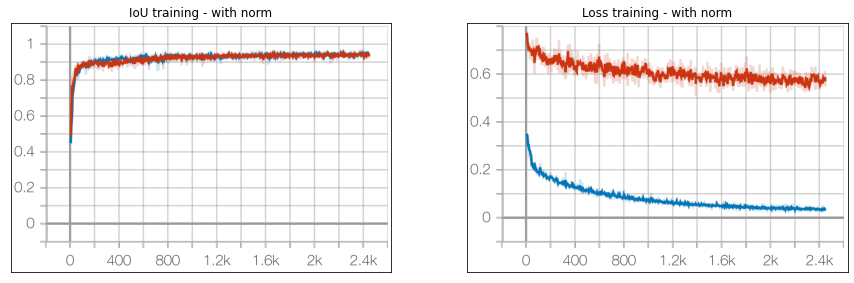

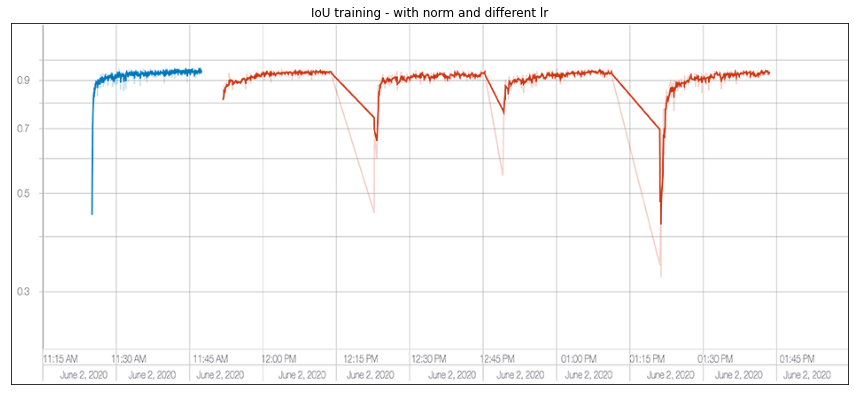

In [40]:
img = imageio.imread(os.path.join(path_images, 'IoU_train_norm_ep5.png'))
ax = plt.subplot(1,2,1)
ax.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.imshow(img)
plt.title("IoU training - with norm")

img = imageio.imread(os.path.join(path_images, 'loss_train_norm_ep5.png'))
ax = plt.subplot(1,2,2)
ax.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.imshow(img)
plt.title("Loss training - with norm")

plt.show()

img = imageio.imread(os.path.join(path_images, 'loU_train_norm_overview_ep5.png'))
ax = plt.subplot(1,1,1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(img)
plt.title("IoU training - with norm and different learning rates")
plt.show()

The last plot shows the IoU of the Sorensen-Dice Loss model in blue followed by different iterations of training of the BCE model in red. From left to right the learning rates are ```10e-4, 10e-3, 10e-4, 10e-5```.

### c) Get creative!
Now run your additional experiments and report your results using the same scheme described above. Don't forget to explain what you implemented and point us to your code (if it is not included in this notebook).

You can find documentation for all the neural network layers implemented in PyTorch at [this link](https://pytorch.org/docs/stable/nn.html) (layer categories are on the right).

##### Exp. 1: Description
*Insert description here*

In [0]:
### NAME EXPERIMENT: your experiment ###

from cvf20.models.unet import UNet

your_model = None

# Build the optimizer:
pass

# Build the trainer:
pass

# Start training:
pass
final_scores = trainer.evaluate_metrics_on_val_set()

##### Exp.1: Comments and Results
*Insert description here*

##### Exp. 2: Description
*Insert description here*

In [0]:
### NAME EXPERIMENT: your experiment ###

from cvf20.models.unet import UNet

your_model = None

# Build the optimizer:
pass

# Build the trainer:
pass

# Start training:
pass
final_scores = trainer.evaluate_metrics_on_val_set()

##### Exp.2: Comments and Results
*Insert description here*